<span style="font-size:29px;">Pulmonary Fibrosis</span><br><br>
<span style="font-size:20px; margin-bottom:10px"><b>What is Pulmonary Fibrosis?</b></span>

   Pulmonary fibrosis is a lung disease that occurs when lung tissue becomes damaged and scarred. This thickened, stiff tissue makes it more difficult for your lungs to work properly. As pulmonary fibrosis worsens, you become progressively more short of breath.

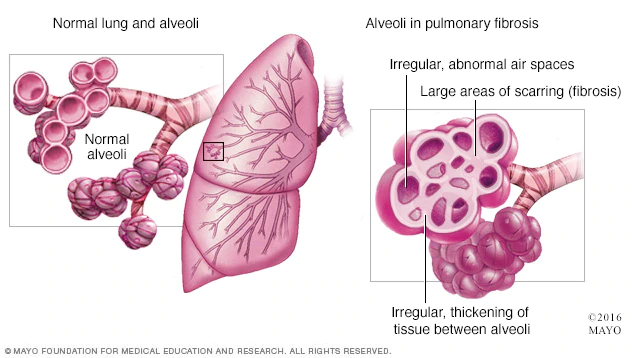
<br>

<span style="font-size:20px; margin-bottom:10px"><b>Risk Factors:</b></span><br>

1) **Age:**
The disorder is much more likely to affect **middle-aged and older adults**.<br><br>
2) **Sex:**
It affects Men more likely than women.
<br><br>
3) **Smoking:**
Smokers and former smokers develop pulmonary fibrosis than do people who have never smoked.


(If you need to more about Pulmonary read these articles, https://www.lung.org/lung-health-diseases/lung-disease-lookup/pulmonary-fibrosis, https://www.mayoclinic.org/diseases-conditions/pulmonary-fibrosis/symptoms-causes/syc-20353690#)

<span style="font-size:20px; margin-bottom:10px"><b>Data Description:</b></span><br><br>
The training set has anonymized, baseline CT scan and the associated details of the patient such as Sex, Age and Smoking Status were provided along with **FVC([Force Vital Capacity](https://www.verywellhealth.com/forced-expiratory-capacity-measurement-914900#)) measurements**.
<br> <br>
FVC of a patient is measured each time he has taken a checkup at hospital from week 0 (negative value means reading taken before week 0) over the course of approximately 1-2 years and is provided along with the CT scan.

Our task is to predict the predict the FVC for the final three weeks for each patient along with it's confidence from the provided FVC value, patient metadata and CT scan.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import re
from PIL import Image
import random
import pydicom
import gc

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv")
test = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv")
sample = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv")

## EDA

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
print(f"Out of 1549 entried there were only {df['Patient'].nunique()} unique patients")

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
sns.countplot(df['Sex'],ax=ax1).set_title("GENDER COUNT OF GIVEN DATA");
sns.countplot(df['SmokingStatus'],ax=ax2).set_title("SMOKING STATUS COUNT OF GIVEN DATA");

In [ ]:
print("Since the data has dupilcated values let's recheck by dropping duplicates")
print()
print("######### GENDER ##########")
print()
print(df[['Patient','Sex','SmokingStatus']].drop_duplicates()['Sex'].value_counts())
print()
print("####### SMOKING STATUS ########")
print()
print(df[['Patient','Sex','SmokingStatus']].drop_duplicates()['SmokingStatus'].value_counts())

In [ ]:
sns.set_style('whitegrid')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))

print(f"FVC minimum value - {df['FVC'].min()}, FVC maximum value - {df['FVC'].max()}                 \
          WEEKS minimum value - {df['Weeks'].min()}, WEEKS maximum value - {df['Weeks'].max()}")

sns.distplot(df['FVC'],ax=ax1,kde=False,bins=40,color='salmon').set_title("FVC DISTRIBUTION");
sns.distplot(df['Weeks'],ax=ax2,kde=False,bins=40,color='salmon').set_title("WEEKS DISTRIBUTION");

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))

print(f"Age minimum value - {df['Age'].min()}, Age maximum value - {df['Age'].max()}                 \
          Percent minimum value - {df['Percent'].min()}, Percent maximum value - {df['Percent'].max()}")

sns.distplot(df['Age'],ax=ax1,kde=False,bins=40,color='plum').set_title("AGE DISTRIBUTION");
sns.distplot(df['Percent'],ax=ax2,kde=False,bins=40,color='plum').set_title("PERCENT DISTRIBUTION");

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,4))
sns.boxplot(df['Percent'],ax=ax1,palette='winter',orient='h').set_title("PERCENTAGE DETAILS");
sns.boxplot(df['Age'],ax=ax2,palette='winter',orient='h').set_title("AGE DETAILS");

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,4))
sns.boxplot(df['FVC'],ax=ax1,palette='winter',orient='h').set_title("FVC DETAILS");
sns.boxplot(df['Weeks'],ax=ax2,palette='winter',orient='h').set_title("WEEKS DETAILS");

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7));
sns.boxplot(df['Sex'],df['FVC'],palette='winter',orient='v',ax=ax1).set_title("GENDER VS FVC");

sns.boxplot(df['SmokingStatus'],df['FVC'],palette='winter',orient='v',ax=ax2).set_title("SMOKING STAT VS FVC");

Clearly Female had much lower FVC than male and as mentioned on Risk Factors it is reason why men are most likely got affected by Pulmonary (may be due to place men work and some other external factors).

FVC value is large for smokers.

In [ ]:
print("######## FVC #########\n")
print(f"Mean FVC of Male {df[df['Sex']=='Male']['FVC'].mean()}")
print(f"Mean FVC of Female {df[df['Sex']=='Female']['FVC'].mean()}\n")

print("######## Smoking Stat #########\n")
print(f"Mean FVC of Smoker {df[df['SmokingStatus']=='Currently smokes']['FVC'].mean()}")
print(f"Mean FVC of Ex-Smoker {df[df['SmokingStatus']=='Ex-smoker']['FVC'].mean()}")
print(f"Mean FVC of Never Smoked {df[df['SmokingStatus']=='Never smoked']['FVC'].mean()}")

In [ ]:
sns.pairplot(hue='Sex',data=df,x_vars=['Weeks','FVC','Percent','Age'],y_vars=['Weeks','FVC','Percent','Age'],height=3);

In [ ]:
print("FVC decreases over time for most of the cases")
plt.figure(figsize = (15,10))
a = sns.lineplot(x = df["Weeks"], y = df["FVC"], hue = df["Patient"], size=1,legend=False)

In [ ]:
df['Photo count'] = 0
names = df['Patient'].unique()
for name in names:
    file = '/kaggle/input/osic-pulmonary-fibrosis-progression/train/'+name
    df.loc[df['Patient']==name,'Photo count'] = len(os.listdir(file))
    
data = df.groupby(by="Patient")["Photo count"].first().reset_index(drop=False)
data = data.sort_values(['Photo count']).reset_index(drop=True)
data['Photo count'].describe()

In [ ]:
plt.figure(figsize=(20,5))
sns.distplot(data['Photo count'],bins=200,kde=False)

Most of the people have CT scan images less than 150 and very rarely people have images greater than 500

In [ ]:
patient_dir = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430"

files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm)
    
files.sort(key=lambda f: int(re.findall('\d+',f)[0]))

datasets = []

for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))
    
fig=plt.figure(figsize=(16, 6))

columns = 10
rows = 3

for i in range(columns*rows):
    img = datasets[i].pixel_array
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap="plasma")
    plt.axis('off');

In [ ]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [ ]:
df.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

In [ ]:
sample['Patient'] = sample['Patient_Week'].apply(lambda x:x.split('_')[0])
sample['Weeks'] = sample['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sample =  sample[['Patient','Weeks','Confidence','Patient_Week']]
sample = sample.merge(test.drop('Weeks', axis=1), on="Patient")

In [ ]:
df['WHERE'] = 'train'
test['WHERE'] = 'val'
sample['WHERE'] = 'test'
data = df.append([test, sample])

In [ ]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [ ]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [ ]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base
gc.collect()

In [ ]:
data[['Sex_Male','SmokingStatus_Ex-smoker','SmokingStatus_Never smoked']] = pd.get_dummies(data[['Sex','SmokingStatus']],drop_first=True)

features = ['Percent','Age','min_FVC','base_week']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

for i in features:
    scaler = MinMaxScaler()
    data[i] = scaler.fit_transform(data[[i]])

In [ ]:
df = data.loc[data.WHERE=='train'].drop('WHERE',axis=1)
test = data.loc[data.WHERE=='val'].drop('WHERE',axis=1)
sample = data.loc[data.WHERE=='test'].drop('WHERE',axis=1)

In [ ]:
features += ['Sex_Male','SmokingStatus_Ex-smoker','SmokingStatus_Never smoked']

In [ ]:
df[features].head()

In [ ]:
X = df[features].values

y = df['FVC'].values

test_ = sample[features].values

y = y.astype('float64') 

In [ ]:
nh = X.shape[1]
pe = np.zeros((test_.shape[0], 3))
pred = np.zeros((X.shape[0], 3))

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(tf.dtypes.cast(y_true[:, 0], tf.float32) - tf.dtypes.cast(fvc_pred, tf.float32))
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    e = tf.dtypes.cast(y_true,tf.float32) - tf.dtypes.cast(y_pred,tf.float32)
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [ ]:
kf = KFold(n_splits=5)
cnt = 0
EPOCHS = 800

for tr_idx, val_idx in kf.split(X):
    cnt += 1
    print(f"FOLD {cnt}")
    model = make_model(nh)
    model.fit(X[tr_idx], y[tr_idx], batch_size=128, epochs=EPOCHS, 
            validation_data=(X[val_idx], y[val_idx]), verbose=0)
    print("train", model.evaluate(X[tr_idx], y[tr_idx], verbose=0, batch_size=128))
    print("val", model.evaluate(X[val_idx], y[val_idx], verbose=0, batch_size=128))
    print("predict val...")
    pred[val_idx] = model.predict(X[val_idx], batch_size=128, verbose=0)
    print("predict test...")
    pe += model.predict(test_, batch_size=128, verbose=0) / 5

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

In [ ]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [ ]:
sample['FVC1'] = 0.996*pe[:, 1]
sample['Confidence1'] = pe[:, 2] - pe[:, 0]

subm = sample[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

**REFERENCES:**

https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter